In [2]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [3]:
with open("preprocessed_data.pkl", "rb") as f:
    data = pickle.load(f)

X_train = data["X_train"].values
X_val   = data["X_val"].values
X_test  = data["X_test"].values
y_train = data["y_train"]
y_val   = data["y_val"]
y_test  = data["y_test"]

In [4]:
def create_sequences(X, y, seq_len=30):
    X_seq = []
    y_seq = []

    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])

    return np.array(X_seq), np.array(y_seq)



In [5]:
SEQ_LEN = 30  # window size

X_train_seq, y_train_seq = create_sequences(X_train, y_train, SEQ_LEN)
X_val_seq,   y_val_seq   = create_sequences(X_val, y_val, SEQ_LEN)
X_test_seq,  y_test_seq  = create_sequences(X_test, y_test, SEQ_LEN)

In [6]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[SEQ_LEN, X_train_seq.shape[2]]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(
        filters=32,
        kernel_size=2,
        padding="causal",
        activation="relu",
        dilation_rate=rate
    ))

model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

# Flatten for regression output
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1))


model.compile(loss="mse", optimizer="adam", metrics=["mae"])


/home/daniel/.local/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [7]:
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=20,
    batch_size=64
)


Epoch 1/20
15579/15579 ━━━━━━━━━━━━━━━━━━━━ 152s 10ms/step - loss: 0.0144 - mae: 0.0887 - val_loss: 0.0124 - val_mae: 0.0805
Epoch 2/20
15579/15579 ━━━━━━━━━━━━━━━━━━━━ 135s 9ms/step - loss: 0.0113 - mae: 0.0770 - val_loss: 0.0117 - val_mae: 0.0812
Epoch 3/20
15579/15579 ━━━━━━━━━━━━━━━━━━━━ 141s 9ms/step - loss: 0.0104 - mae: 0.0734 - val_loss: 0.0106 - val_mae: 0.0750
Epoch 4/20
15579/15579 ━━━━━━━━━━━━━━━━━━━━ 130s 8ms/step - loss: 0.0098 - mae: 0.0712 - val_loss: 0.0111 - val_mae: 0.0796
Epoch 5/20
15579/15579 ━━━━━━━━━━━━━━━━━━━━ 138s 9ms/step - loss: 0.0094 - mae: 0.0696 - val_loss: 0.0099 - val_mae: 0.0728
Epoch 6/20
15579/15579 ━━━━━━━━━━━━━━━━━━━━ 142s 9ms/step - loss: 0.0091 - mae: 0.0683 - val_loss: 0.0099 - val_mae: 0.0709
Epoch 7/20
15579/15579 ━━━━━━━━━━━━━━━━━━━━ 146s 9ms/step - loss: 0.0089 - mae: 0.0673 - val_loss: 0.0106 - val_mae: 0.0722
Epoch 8/20
15579/15579 ━━━━━━━━━━━━━━━━━━━━ 136s 9ms/step - loss: 0.0087 - mae: 0.0666 - val_loss: 0.0096 - val_mae: 0.0687
Epoch 9

In [10]:
preds = model.predict(X_test_seq).flatten()
rmse = np.sqrt(mean_squared_error(y_test_seq, preds))

print(f"RMSE for WaveNet: {rmse:.4f}")


6676/6676 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step
 RMSE: 0.09304463230544957
RMSE for WaveNet: 0.0930


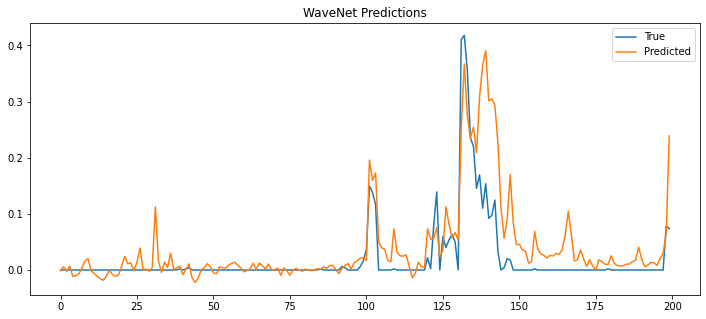

In [9]:
plt.figure(figsize=(12,5))
plt.plot(y_test_seq[:200], label="True")
plt.plot(preds[:200], label="Predicted")
plt.title("WaveNet Predictions")
plt.legend()
plt.show()